In [1]:
import itk
import numpy as np
import os
import reader

In [2]:
# Load data
t1_1_dir = "data/t1_3"
t1_2_dir = "data/t1_20"
t1_1_image, t1_1_reader = reader.dicom_to_itk(t1_1_dir)
t1_2_image, t1_2_reader = reader.dicom_to_itk(t1_2_dir)
t1_1_npa = itk.GetArrayFromImage(t1_1_image)
t1_2_npa = itk.GetArrayFromImage(t1_2_image)

# Collect parameters
shape = np.shape(t1_1_npa)
if shape != np.shape(t1_2_npa):
    print('Warning: T1 images of different shape.')
    
t1_1_tags = t1_1_reader.GetMetaDataDictionaryArray()[0]
t1_2_tags = t1_2_reader.GetMetaDataDictionaryArray()[0]

t1_1_fa = int(t1_1_tags['0018|1314'])
t1_2_fa = int(t1_2_tags['0018|1314'])
flip_angles = np.array([t1_1_fa, t1_2_fa])
flip_angles_rad = flip_angles*np.pi/180;

t1_1_tr = int(t1_1_tags['0018|0080'])
t1_2_tr = int(t1_2_tags['0018|0080'])
if t1_1_tr != t1_2_tr:
    print('Warning: T1 images with different TR.')
tr = t1_1_tr

In [3]:
t1_1_npa = t1_1_npa.flatten()
t1_2_npa = t1_2_npa.flatten()
signal = np.vstack((t1_1_npa, t1_2_npa))

In [4]:
y = np.zeros(np.shape(signal))
x = np.zeros(np.shape(signal))
for n, alpha in enumerate(flip_angles_rad):
    y[n] = signal[n]/np.sin(alpha)
    x[n] = signal[n]/np.tan(alpha)

In [5]:
# Simple linear regression
y_vals = y[1] - y[0]
x_vals = x[1] - x[0]
gradient = np.divide(y_vals, x_vals, 
                     out=np.zeros_like(y_vals), where=x_vals!=0)
gradient[gradient<0] = 0
gradient[gradient>=1] = 0
intercept = y[1] - gradient * x[1]
intercept = np.nan_to_num(intercept)
intercept[intercept<0] = 0

In [6]:
# M0 and T1 maps
m0 = np.divide(intercept, 1 - gradient)
t1 = np.divide(-tr, np.log(gradient), 
               out=np.zeros_like(gradient), where=gradient!=0)

divide by zero encountered in log


In [7]:
m0 = np.reshape(m0, shape)
t1 = np.reshape(t1, shape)

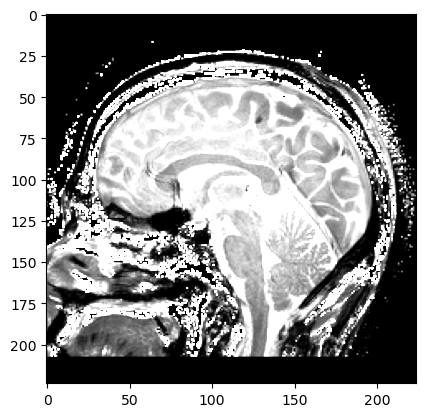

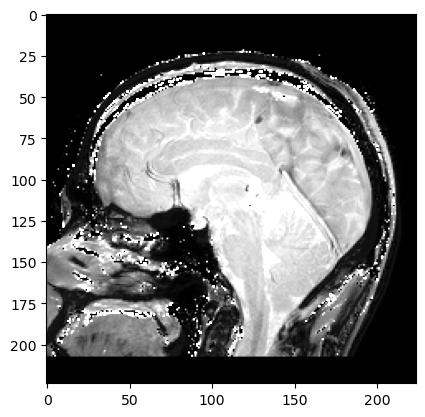

In [8]:
import matplotlib.pyplot as plt

slice_n = int(shape[0]/2)
plt.imshow(t1[slice_n,:,:],cmap=plt.cm.Greys_r)
plt.clim(0, 2500)  # Typical T1 for CSF = 2500 ms
plt.show()

plt.imshow(m0[slice_n,:,:],cmap=plt.cm.Greys_r)
plt.clim(0, 50000)
plt.show()